In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
# from ROI_extraction import preprocess_image
import cv2
import os
# Set the path to dataset
dataset_path = '../images/3regimes/'

ids = []
labels = {}
classes = {'excess':1,'normal':0,'insufficient':2}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path) :
            if filename.endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(class_path, filename) 
                ids.append(img_path)
                labels[img_path]=classes[class_name]

# Set the input image dimensions
img_width, img_height = 100, 100
n_channels = 3

params = {'dim': (img_height,img_width),
          'batch_size': 64,
          'n_classes': 3,
          'n_channels': n_channels,
          'shuffle': False}

# Set the number of classes
num_classes = 3

def correct_gamma(image):
    # Convert image to float and normalize to range 0-1
    image_normalized = image.astype(float) / 255.0

    # Calculate mean R intensity
    meanRimg = np.mean(image_normalized[:, :, 2])  # Image is in BGR format
    
    # Calculate G value
    G = 0.74 * np.exp(-3.97 * meanRimg)
    
    # Apply transformation
    transformed_image = np.power(image_normalized, 1 / G)
    img_float32 = np.float32(transformed_image)
    return img_float32

def extract_ROI(original_image):
    # Convert to grayscale
    gray_image = cv2.cvtColor((original_image*255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    # # Apply histogram normalization
    # normalized_image = cv2.equalizeHist(gray_image)
    
    # Apply median filtering
    filtered_image = cv2.medianBlur(gray_image, 5)
    
    # Apply Otsu's thresholding
    _, thresholded_image = cv2.threshold(filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)
    opened_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)

    # Find contours in the processed image
    contours, _ = cv2.findContours(opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    
    # Calculate the moments of the contour
    M = cv2.moments(contour)
    
    # Calculate the center of the contour
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    
    # Calculate the coordinates of the square ROI
    roi_size = img_height
    roi_x = center_x - roi_size // 2
    roi_y = center_y - roi_size // 2
    
    return {'contours':contours,'roi_x':roi_x,'roi_y':roi_y,'roi_size':roi_size}

def data_generation(list_IDs_temp):
    y = np.empty((len(list_IDs_temp)), dtype=int)
    X = []
    for i, ID in enumerate(list_IDs_temp):
        image = cv2.imread(ID)
        img_gamma_correct = correct_gamma(image)
        ROI = extract_ROI(img_gamma_correct)
        ROI = image[ROI['roi_y']:ROI['roi_y']+ROI['roi_size'], ROI['roi_x']:ROI['roi_x']+ROI['roi_size']]
        img = cv2.cvtColor(ROI, cv2.COLOR_BGR2HSV)
        H_val,S_val,V_val = img[:,:,0],img[:,:,1],img[:,:,2]
        # Extract the mean values of hue, saturation, and value
        H_mean = np.mean(H_val)
        S_mean = np.mean(S_val)
        V_mean = np.mean(V_val)
        # Extract the standard deviation of hue, saturation, and value
        H_std = np.std(H_val)
        S_std = np.std(S_val)
        V_std = np.std(V_val)
        # Extract the contrast values of hue, saturation, and value
        # H_max,S_max,V_max = np.max(H_val),np.max(S_val),np.max(V_val)
        # H_min,S_min,V_min = np.min(H_val),np.min(S_val),np.min(V_val)
        # H_contrast = (H_max - H_min) / (H_max + H_min)
        # S_contrast = (S_max - S_min) / (S_max + S_min)
        # V_contrast = (V_max - V_min) / (V_max + V_min)
        X.append([H_mean,H_std,S_mean,S_std,V_mean,V_std])
        y[i] = labels[ID]
    return pd.DataFrame(X,columns=['H_mean','H_std','S_mean','S_std','V_mean','V_std']),keras.utils.to_categorical(y, num_classes=params['n_classes']),y


In [2]:
X,y_categorical,y = data_generation(ids)

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# Nombre de plis pour la validation croisée k-fold
k = 5

# Créer une instance de StratifiedKFold avec k plis
skf = StratifiedKFold(n_splits=k)


In [4]:
# ChangeFinder
def findChangePoints_changeFinder(ts, r, order, smooth):
    '''
       r: Discounting rate
       order: AR model order
       smooth: smoothing window size T
    '''
    cf = changefinder.ChangeFinder(r=r, order=order, smooth=smooth)
    ts_score = [cf.update(p) for p in ts]
    
    return ts_score

def plotChangePoints_changeFinder(df, ts, ts_score, title):
        
    fig, ax1 = plt.subplots(figsize=(16,4))
    ax2 = ax1.twinx()
    ax1.plot(df.index, ts)
    ax2.plot(df.index, ts_score, color='red')
    
    ax1.set_ylabel('item sale')
    ax1.grid(axis='x', alpha=0.7)
    
    ax2.set_ylabel('CP Score')
    ax2.set_title(title)
    plt.show()

In [5]:
import changefinder

In [11]:
print(len(X))

5010


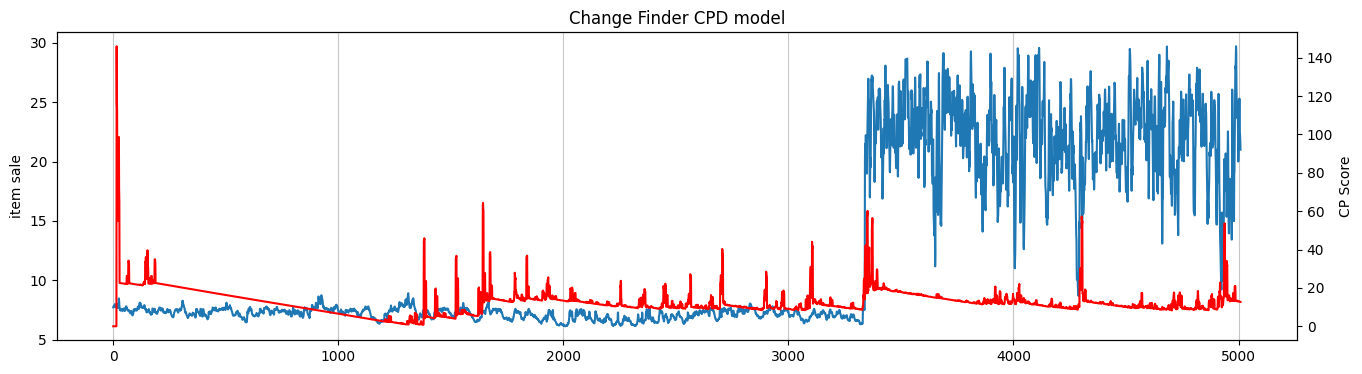

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

tsd = np.array(X['H_mean'])

cp_score = findChangePoints_changeFinder(tsd, r=0.01, order=3, smooth=7)
plotChangePoints_changeFinder(X, tsd, cp_score, 'Change Finder CPD model')
